In [1]:
import sys
sys.path.append('../')

import jax
# set jax precision 64 bit
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from src.trees import get_1d_tree, get_data_1d, plot_1d_tree, is_far, get_real_features
from src.trees import flatten_around_point, get_features, plot_1d_tree, data_plotter
from src.trees import potential_from_features, potential_from_points
from flax.training import train_state
import optax
import jax
import jax.numpy as jnp
import time
from flax import linen as nn


class MultiHeadSelfAttention(nn.Module):
    embed_dim: int
    num_heads: int

    def setup(self):
        assert self.embed_dim % self.num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.head_dim = self.embed_dim // self.num_heads
        self.qkv_proj = nn.Dense(self.embed_dim * 3)  # For Query, Key, Value
        self.out_proj = nn.Dense(self.embed_dim)

    def __call__(self, x, mask=None):
        batch_size, seq_len, embed_dim = x.shape 
        assert embed_dim == self.embed_dim, "Input embedding dimension does not match module embedding dimension."
        
        qkv = self.qkv_proj(x)  # Shape: (batch_size, seq_len, embed_dim * 3)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        q, k, v = jnp.split(qkv, 3, axis=2)  # Each: (batch_size, seq_len, num_heads, head_dim)
        q, k, v = q.squeeze(2), k.squeeze(2), v.squeeze(2)

        # Compute attention weights
        attn_weights = jnp.einsum("bqhd,bkhd->bhqk", q, k) / jnp.sqrt(self.head_dim)
        if mask is not None:
            # Apply mask: set weights to -inf where mask is 0
            attn_weights = jnp.where(mask[:, None, None, :], attn_weights, -1e9)
        attn_weights = jax.nn.softmax(attn_weights, axis=-1)

        # Compute attention output
        attn_output = jnp.einsum("bhqk,bkhd->bqhd", attn_weights, v)
        attn_output = attn_output.reshape(batch_size, seq_len, self.embed_dim)
        return self.out_proj(attn_output)

class TransformerEncoderLayer(nn.Module):
    embed_dim: int
    num_heads: int
    ff_hidden_dim: int
    #dropout_rate: float

    def setup(self):
        self.attention = MultiHeadSelfAttention(self.embed_dim, self.num_heads)
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()
        self.feed_forward = nn.Sequential([
            nn.Dense(self.ff_hidden_dim),
            nn.gelu,
            nn.Dense(self.embed_dim),
        ])
        #self.dropout = nn.Dropout(rate=self.dropout_rate)

    def __call__(self, x, mask=None, train: bool = True):
        # Multi-head self-attention
        attn_out = self.attention(x, mask)
        x = self.norm1(x + attn_out)# self.norm1(x + attn_out)#self.dropout(attn_out, deterministic=not train))
        # Feed-forward network
        ff_out = self.feed_forward(x)
        x = self.norm2(x + ff_out) #self.norm2(x + ff_out)#self.dropout(ff_out, deterministic=not train))
        return x

class Transformer(nn.Module):
    embed_dim: int
    num_heads: int
    ff_hidden_dim: int
    num_layers: int
    #dropout_rate: float

    def setup(self):
        self.layers = [
            TransformerEncoderLayer(self.embed_dim, self.num_heads, self.ff_hidden_dim)#, self.dropout_rate)
            for _ in range(self.num_layers)
        ]
        self.final_norm = nn.LayerNorm()
        self.output_layer = nn.Dense(1)  # Produces a single scalar output

    def __call__(self, x, mask, train: bool = True):
        # Apply each Transformer Encoder layer
        for layer in self.layers:
            x = layer(x, mask, train=train)
        x = self.final_norm(x)
        # Global average pooling to make the output independent of sequence length
        x = jnp.sum(x * mask[:, :, None], axis=1) #/ jnp.sum(mask, axis=1, keepdims=True)
        # Final projection to a single output
        x = jnp.sum(x, axis=1)#self.output_layer(x)
        #x = self.output_layer(x)
        return x

# Example usage

def make_batches(key, *data, batch_size=16, shuffle=True):
    num_batches = len(data[0]) // batch_size
    if shuffle:
        perm = jax.random.permutation(key, len(data[0]))
        data = [x[perm] for x in data]
    return [tuple(d[i*batch_size:(i+1)*batch_size] for d in data) for i in range(num_batches)]
    
    
def compute_loss(params, func, x, y, mask):
    y_est = func(params, x, mask)
    #return jnp.mean((y_est - y)**2/y**2)
    return jnp.mean((y_est-y)**2)# / jnp.mean((y-jnp.mean(y))**2)

@jax.jit
def train_step(state, x, y, mask):
    """
    Performs a single optimization step.
    Args:
        state: A TrainState object containing the optimizer state and model parameters.
        batch: A tuple (inputs, targets) for this batch.
        mask: Padding mask for the input sequences.
    Returns:
        Updated TrainState and loss value.
    """
    
    def loss_fn(params):
        return compute_loss(params, state.apply_fn, x, y, mask)

    # Compute gradients
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    # Apply gradients
    state = state.apply_gradients(grads=grads)
    return state, loss


# Initialize the optimizer and training state
def create_train_state(rng, model, input_shape, mask_shape, learning_rate, num_epochs):
    """
    Creates the training state, including initialized model parameters and the optimizer.
    Args:
        model: The Transformer model.
        rng: Random number generator.
        input_shape: Shape of the input tensor.
        mask_shape: Shape of the mask tensor.
        learning_rate: Learning rate for the optimizer.
    Returns:
        A TrainState object.
    """
    rng, subrng = jax.random.split(rng)
    
    dummy_inputs = jax.random.normal(rng, input_shape)
    dummy_mask = jnp.ones(mask_shape)
    params = model.init(subrng, dummy_inputs, dummy_mask)
    #tx = optax.adam(learning_rate)
    lr_schedule = optax.cosine_decay_schedule(init_value=learning_rate, decay_steps=num_epochs)
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),  # Gradient clipping
        optax.adamw(lr_schedule)  # AdamW optimizer with learning rate scheduling
    )
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Example training loop
def train_model(rng, model, x_train, y_train, mask_train, batch_size, num_epochs, learning_rate):
    """
    Trains the Transformer model.
    Args:
        model: The Transformer model.
        train_data: A dataset of (inputs, targets) pairs.
        train_masks: A dataset of masks corresponding to the inputs.
        num_epochs: Number of epochs to train for.
        learning_rate: Learning rate for the optimizer.
        rng: Random number generator.
    Returns:
        Trained model parameters.
    """
    _, seq_len, embed_dim = x_train.shape  # (batch_size, seq_len, embed_dim)
    rng, subrng = jax.random.split(rng)
    state = create_train_state(subrng, model, (batch_size, seq_len, embed_dim), (batch_size, seq_len,), learning_rate, num_epochs)

    avg_losses = []
    max_losses = []
    min_losses = []
    
    t = time.time()
    jit_train_step = jax.jit(train_step)
    for epoch in range(num_epochs):
        rng, subrng = jax.random.split(rng)
        batches = make_batches(subrng, x_train, y_train, mask_train, batch_size=batch_size)
        epoch_losses = []
        for (x, y, mask) in batches:
            state, loss = jit_train_step(state, x, y, mask)
            epoch_losses.append(loss**0.5)
        
        epoch_losses = jnp.array(epoch_losses)
        avg_losses.append(jnp.mean(epoch_losses))
        max_losses.append(jnp.max(epoch_losses))
        min_losses.append(jnp.min(epoch_losses))
        t_left = (time.time() - t) * (num_epochs-epoch)/(epoch+1)# in minutes
        t_h = jnp.floor(t_left/3600)
        t_m = jnp.floor((t_left - t_h*3600)/60)
        t_s = t_left - t_m*60 - t_h*3600
        print(f"Epoch {epoch}/{num_epochs}, {t_h:.0f}h{t_m:.0f}m{t_s:.0f}s left, Avg. Loss: {avg_losses[-1]:.2e}, Max Loss: {max_losses[-1]:.2e}, Min Loss: {min_losses[-1]:.2e}", end='\r')

    return state.params, avg_losses, max_losses, min_losses

In [ ]:
data = jnp.load("data/train_data.npy", allow_pickle=True).item()
x_train_pad = data["x"]
y_train_pad = data["y"]
mask_train_pad = data["mask"]

#x_train_pad_std = jnp.std(x_train_pad, axis=(0,1))
#x_train_pad_mean = jnp.mean(x_train_pad, axis=(0,1))
#x_train_pad = (x_train_pad - x_train_pad_mean) / x_train_pad_std

#y_train_pad_std = jnp.std(y_train_pad)
#y_train_pad_mean = jnp.mean(y_train_pad)
#y_train_pad = (y_train_pad - y_train_pad_mean) / y_train_pad_std


key = jax.random.PRNGKey(0)

# MODEL
num_epochs= 10000
num_heads = 1
ff_hidden_dim = 128
num_layers = 6
batch_size = 32

key = jax.random.PRNGKey(0)
num_data, seq_len, embed_dim = x_train_pad.shape
model = Transformer(embed_dim, num_heads, ff_hidden_dim, num_layers)#, dropout_rate)
params, avg_losses, max_losses, min_losses  = train_model(key, model, x_train_pad, y_train_pad, mask_train_pad, batch_size, num_epochs, 1e-3)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
training_result = {"params": params, "avg_losses": avg_losses, "max_losses": max_losses, "min_losses": min_losses}
jnp.save("results2.npy", training_result)

14.468115150314162


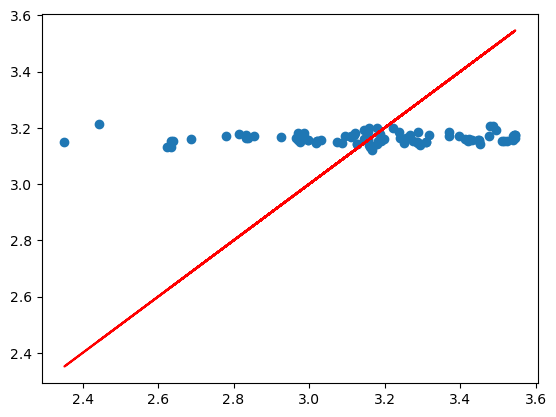

In [ ]:
#plt.plot(avg_losses)
y_eval_pad = model.apply(params, x_train_pad, mask_train_pad)
plt.scatter(y_train_pad, y_eval_pad)
plt.plot(y_train_pad, y_train_pad, color='red')
print((jnp.mean((y_train_pad-y_eval_pad)**2)/jnp.mean((y_eval_pad-jnp.mean(y_eval_pad))**2))**0.5)


In [5]:
# Training observations:
# - Loss is choppy (shoots back up and then down)
# - Stays at 0.1
# - Model should be able to fit the data

# Next steps:
# - Try to overfit a simple function (1. everywhere worked)
# - Try to overfit on a small data set ()
# - 

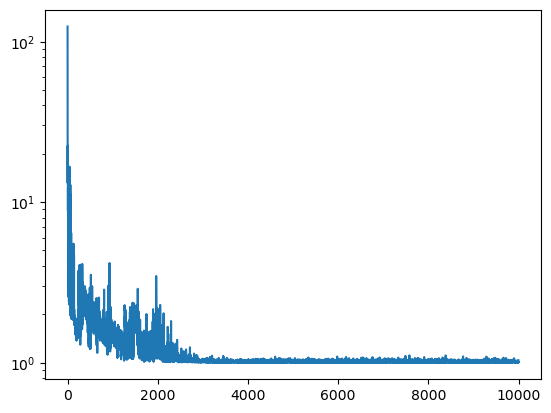

In [ ]:
plt.semilogy(avg_losses)